In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import math
import warnings
from sklearn import linear_model

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn import neighbors


In [31]:
# importing data sets

# 2013
crimestats_baseline_2013 = pd.read_csv('Thinkful 2_4 dataframe.csv')
crimestats13 = crimestats_baseline_2013

# 2014
crimestats_baseline_2014 = pd.read_csv('Thinkful 2_5 dataframe NY crime 2014.csv')
crimestats14 = crimestats_baseline_2014


In [32]:
# cleaning 2013 data

# renaming the columns to fix the non-standard text in them
crimestats13.columns = ['City', 'Population', 'Violent_Crime', 'Murder_and_Nonnegligent_Manslaughter', 'Rape_Revised','Rape_Legacy','Robbery','Aggravated_Assault','Property_Crime','Burglary','Larceny_Theft','Motor_Vehicle_Theft','Arson']

#dropping the first four rows to remove the non-numeric title fluff
crimestats13.drop([0,1,2,3], axis=0, inplace=True)

#dropping the last three rows to remove the non-numeric title fluff
crimestats13.drop([352,353,354], axis=0, inplace=True)

# dropping the Rape 1 column due to it not having any contents
crimestats13.drop('Rape_Revised', axis=1, inplace=True)
crimestats13.drop('Rape_Legacy', axis=1, inplace=True)

# dropping the Arson column due to it having so many NaN values
crimestats13.drop('Arson', axis=1, inplace=True)

# Remove 293: Seneca Falls Town due to the massive differential in per-1000-people burglary, property crime, 
# and larceny that it has relative to other cities.
# Remove 220: New York (city) because of just how much of an outlier it is from the rest of the cities.
crimestats13.drop(293, axis=0, inplace=True)
crimestats13.drop(220, axis=0, inplace=True)

# Removing outliers that showed up in model execution
crimestats13.drop(7, axis=0, inplace=True)
crimestats13.drop(11, axis=0, inplace=True)
crimestats13.drop(39, axis=0, inplace=True)
crimestats13.drop(130, axis=0, inplace=True)
crimestats13.drop(276, axis=0, inplace=True)
crimestats13.drop(314, axis=0, inplace=True)
crimestats13.drop(350, axis=0, inplace=True)

# cleaning up the data by removing commas and changing the contents from str to int
def comma_cleaning_and_int(x):
    crimestats13[x] = crimestats13[x].str.replace(',', '')
    crimestats13[x] = crimestats13[x].astype(int)

comma_cleaning_and_int('Population')
comma_cleaning_and_int('Violent_Crime')
comma_cleaning_and_int('Murder_and_Nonnegligent_Manslaughter')
comma_cleaning_and_int('Robbery')
comma_cleaning_and_int('Aggravated_Assault')
comma_cleaning_and_int('Property_Crime')
comma_cleaning_and_int('Burglary')
comma_cleaning_and_int('Larceny_Theft')
comma_cleaning_and_int('Motor_Vehicle_Theft')

# adding in features requested in the drill
def yesno(x):
    if x > 0:
        return 1
    else:
        return 0

crimestats13['murder_yesno'] = crimestats13.apply(lambda row: yesno(row['Murder_and_Nonnegligent_Manslaughter']), axis=1)
crimestats13['robbery_yesno'] = crimestats13.apply(lambda row: yesno(row['Robbery']), axis=1)

# creating features using the ratio of crime to population
def popratio(x,y):
    return (1000*(x/y))

crimestats13['violent_crime_per1000'] = 1000 * crimestats13['Violent_Crime'] / crimestats13['Population']
crimestats13['murder_per1000'] = 1000 * crimestats13['Murder_and_Nonnegligent_Manslaughter'] / crimestats13['Population']
crimestats13['robbery_per1000'] = 1000 * crimestats13['Robbery'] / crimestats13['Population']
crimestats13['assault_per1000'] = 1000 * crimestats13['Aggravated_Assault'] / crimestats13['Population']
crimestats13['propertycrime_per1000'] = 1000 * crimestats13['Property_Crime'] / crimestats13['Population']
crimestats13['burglary_per1000'] = 1000 * crimestats13['Burglary'] / crimestats13['Population']
crimestats13['larceny_per1000'] = 1000 * crimestats13['Larceny_Theft'] / crimestats13['Population']
crimestats13['motorvehicle_crime_per1000'] = 1000 * crimestats13['Motor_Vehicle_Theft'] / crimestats13['Population']

# creating a sqrt feature for property crime
crimestats13['propertycrime_per1000_sqrt'] = crimestats13['propertycrime_per1000']**.5

# creating PCA features for violent and property crimes
pca = PCA(n_components=1) 
X_reg1 = pca.fit_transform(crimestats13[['propertycrime_per1000_sqrt', 'burglary_per1000', 'larceny_per1000']])
crimestats13['property_crime_pca'] = X_reg1

X_reg2 = pca.fit_transform(crimestats13[['violent_crime_per1000', 'robbery_per1000']])
crimestats13['violent_crime_pca'] = X_reg2

In [33]:
# cleaning 2014 data

# renaming the columns to fix the non-standard text in them
crimestats14.columns = ['City', 'Population', 'Violent_Crime', 'Murder_and_Nonnegligent_Manslaughter', 'Rape_Revised','Rape_Legacy','Robbery','Aggravated_Assault','Property_Crime','Burglary','Larceny_Theft','Motor_Vehicle_Theft','Arson']

#dropping the first four rows to remove the non-numeric title fluff
crimestats14.drop([0,1,2,3], axis=0, inplace=True)

#dropping the last three rows to remove the non-numeric title fluff
crimestats14.drop([377,376,375,374,373], axis=0, inplace=True)

# dropping the Rape columns due to them having so many NaN values
crimestats14.drop('Rape_Revised', axis=1, inplace=True)
crimestats14.drop('Rape_Legacy', axis=1, inplace=True)

# dropping the Arson column due to it having so many NaN values
crimestats14.drop('Arson', axis=1, inplace=True)

# cleaning up the data by removing commas and changing the contents from str to int
crimestats14.fillna(0, inplace=True)

def comma_cleaning_and_int(x):
    crimestats14[x] = crimestats14[x].astype(str)
    crimestats14[x] = crimestats14[x].str.replace(',', '')
    crimestats14[x] = crimestats14[x].astype(int)

comma_cleaning_and_int('Population')
comma_cleaning_and_int('Violent_Crime')
comma_cleaning_and_int('Murder_and_Nonnegligent_Manslaughter')
comma_cleaning_and_int('Robbery')
comma_cleaning_and_int('Aggravated_Assault')
comma_cleaning_and_int('Property_Crime')
comma_cleaning_and_int('Burglary')
comma_cleaning_and_int('Larceny_Theft')
comma_cleaning_and_int('Motor_Vehicle_Theft')

# adding in features requested in the drill
crimestats14['murder_yesno'] = crimestats14.apply(lambda row: yesno(row['Murder_and_Nonnegligent_Manslaughter']), axis=1)
crimestats14['robbery_yesno'] = crimestats14.apply(lambda row: yesno(row['Robbery']), axis=1)

# creating features using the ratio of crime to population
crimestats14['violent_crime_per1000'] = 1000 * crimestats14['Violent_Crime'] / crimestats14['Population']
crimestats14['murder_per1000'] = 1000 * crimestats14['Murder_and_Nonnegligent_Manslaughter'] / crimestats14['Population']
crimestats14['robbery_per1000'] = 1000 * crimestats14['Robbery'] / crimestats14['Population']
crimestats14['assault_per1000'] = 1000 * crimestats14['Aggravated_Assault'] / crimestats14['Population']
crimestats14['propertycrime_per1000'] = 1000 * crimestats14['Property_Crime'] / crimestats14['Population']
crimestats14['burglary_per1000'] = 1000 * crimestats14['Burglary'] / crimestats14['Population']
crimestats14['larceny_per1000'] = 1000 * crimestats14['Larceny_Theft'] / crimestats14['Population']
crimestats14['motorvehicle_crime_per1000'] = 1000 * crimestats14['Motor_Vehicle_Theft'] / crimestats14['Population']

# Remove outliers in boxplot data
crimestats14.drop(11, axis=0, inplace=True)
crimestats14.drop(42, axis=0, inplace=True)
crimestats14.drop(56, axis=0, inplace=True)
crimestats14.drop(225, axis=0, inplace=True)
crimestats14.drop(233, axis=0, inplace=True)
crimestats14.drop(215, axis=0, inplace=True)
crimestats14.drop(151, axis=0, inplace=True)
crimestats14.drop(245, axis=0, inplace=True)

# Remove 231: New York (city) because of just how much of an outlier it is from the rest of the cities.
crimestats14.drop(231, axis=0, inplace=True)

# Remove outliers in model run
crimestats14.drop(287, axis=0, inplace=True)
crimestats14.drop(330, axis=0, inplace=True)
crimestats14.drop(370, axis=0, inplace=True)

# creating a sqrt feature for property crime
crimestats14['propertycrime_per1000_sqrt'] = crimestats14['propertycrime_per1000']**.5

# creating PCA features for violent and property crimes
pca = PCA(n_components=1) 
X_reg1 = pca.fit_transform(crimestats14[['propertycrime_per1000_sqrt', 'burglary_per1000', 'larceny_per1000']])
crimestats14['property_crime_pca'] = X_reg1

X_reg2 = pca.fit_transform(crimestats14[['violent_crime_per1000', 'robbery_per1000']])
crimestats14['violent_crime_pca'] = X_reg2

In [137]:
# basic linear regression model

regr = linear_model.LinearRegression()

crimestats_train = crimestats13
crimestats_test = crimestats14

Y_train = crimestats_train['Property_Crime'].values.reshape(-1, 1)
X_train = crimestats_train[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

Y_test = crimestats_test['Property_Crime'].values.reshape(-1, 1)
X_test = crimestats_test[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

regr.fit(X_train, Y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n2013 R-squared:')
print(regr.score(X_train, Y_train))

# test it on 2014 data
print('\n2014 test R-squared: \n', regr.score(X_test, Y_test))



Coefficients: 
 [[ 2.21609631e-02 -1.07935683e+02  1.11526472e+01  4.72607986e+01]]

Intercept: 
 [51.74410197]

2013 R-squared:
0.8350934318479228

2014 test R-squared: 
 0.8410394295551001


In [138]:
# running the model against the 2014 data

predicted = regr.predict(X_test).ravel()
actual = Y_test
residual = actual - predicted

correlation_matrix = X_test.corr()
display(correlation_matrix)

# Cross Validation, 10 samples
sklearn.model_selection.cross_val_score(regr, X_test, Y_test, cv = 10)



,Population,robbery_yesno,property_crime_pca,violent_crime_pca
Population,1.000,0.473,0.190,0.369
robbery_yesno,0.473,1.000,0.377,0.442
property_crime_pca,0.190,0.377,1.000,0.522
violent_crime_pca,0.369,0.442,0.522,1.000


array([0.86710116, 0.89462542, 0.6715176 , 0.88993686, 0.83572963,
       0.38823976, 0.70693663, 0.42289366, 0.87737735, 0.83129928])

In [139]:
# F-test and p-values of the features selected
sklearn.feature_selection.f_regression(crimestats13[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']], crimestats13['Property_Crime'])

(array([744.60313924,  78.23871489,  79.51586254, 144.04039027]),
 array([2.41817165e-87, 5.21602360e-17, 3.08918712e-17, 7.15734969e-28]))

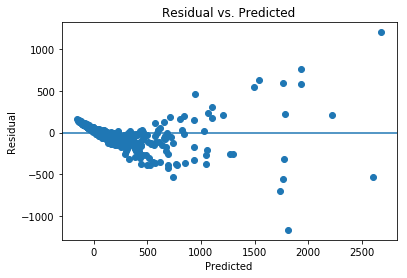

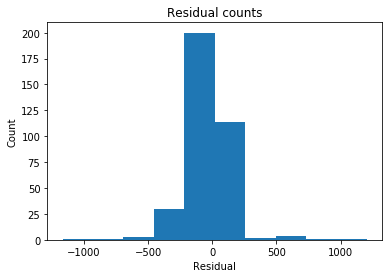

33527.72158446327

In [140]:
predicted = regr.predict(X_test)
actual = Y_test
residual = actual - predicted

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

sklearn.metrics.mean_squared_error(actual, predicted)

In [141]:
# KNN models

# Y_train = crimestats_train['Property_Crime'].values.reshape(-1, 1)
# X_train = crimestats_train[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

# Y_test = crimestats_test['Property_Crime'].values.reshape(-1, 1)
# X_test = crimestats_test[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

k = 48

knn = neighbors.KNeighborsRegressor(n_neighbors=k)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')

knn.fit(X_train, Y_train)
knn_w.fit(X_train, Y_train)

sklearn.model_selection.cross_val_score(knn_w, X_test, Y_test, cv = 10)


array([0.62803569, 0.7230135 , 0.60440074, 0.84503832, 0.62026251,
       0.64937168, 0.62196363, 0.56423482, 0.63785176, 0.65677563])

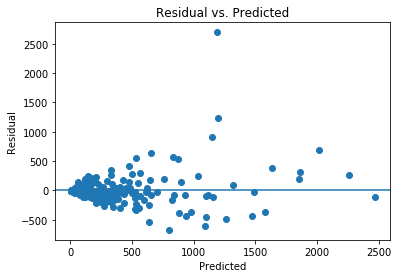

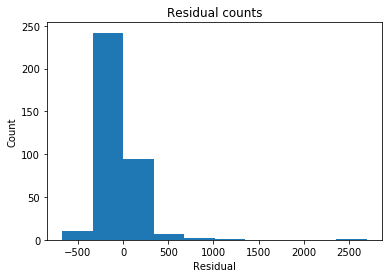

48480.61494799799

In [142]:
predicted = knn_w.predict(X_test)
actual = Y_test
residual = actual - predicted

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

sklearn.metrics.mean_squared_error(actual, predicted)

In [143]:
# Comparing the mean accuracy of the models

score_r = cross_val_score(regr, X_test, Y_test, cv=10)
print("Linear Regression Accuracy: %0.2f (+/- %0.2f)" % (score_r.mean(), score.std() * 2))
score = cross_val_score(knn, X_test, Y_test, cv=10)
print("Unweighted KNN Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_test, Y_test, cv=10)
print("Distance-Weighted KNN Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Linear Regression Accuracy: 0.74 (+/- 0.12)
Unweighted KNN Accuracy: 0.57 (+/- 0.16)
Distance-Weighted KNN Accuracy: 0.66 (+/- 0.15)


The linear regression is, at least with these features, the clear winner between linear and knn regression.  Even with optimized k, the KNNR model can only get to 66% accuracy, while the LR model achieves 74% accuracy, with similar standard deviations.  

As for whether there would be a preferable, it's worth noting that the KNNR model makes more large overestimates and more small underestimates, which shifts the average error upwards and implies that some further tinkering, either with features or by pruning out the right kinds of outliers, might result in a more accurate model.  

However, I have no idea how *much* tinkering would be required, and in any case I think that Linear Regression is the more appropriate tool for this particular dataset, specifically because net crime levels are not as "clumpy" as you really need for KNN to function properly.  

In [133]:
# Testing the models' accuracy when estimating Property Crime *rates* as opposed to total property crime

Y_train = crimestats_train['propertycrime_per1000'].values.reshape(-1, 1)
X_train = crimestats_train[['robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

Y_test = crimestats_test['propertycrime_per1000'].values.reshape(-1, 1)
X_test = crimestats_test[['robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

regr.fit(X_train, Y_train)
knn_w.fit(X_train, Y_train)

score_r = cross_val_score(regr, X_test, Y_test, cv=10)
print("Linear Regression Accuracy: %0.2f (+/- %0.2f)" % (score_r.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_test, Y_test, cv=10)
print("Distance-Weighted KNN Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Linear Regression Accuracy: 0.99 (+/- 0.12)
Distance-Weighted KNN Accuracy: 0.96 (+/- 0.08)


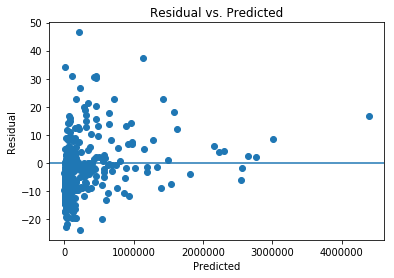

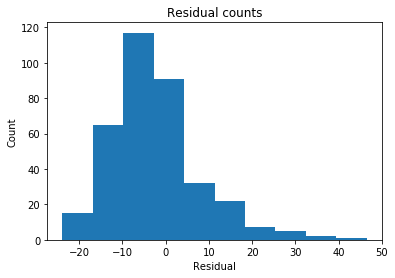

6270912279.551544

In [134]:
predicted_ratetest = regr.predict(X_test) * crimestats_test['Population'].values.reshape(-1, 1)
actual_ratetest = Y_test * crimestats_test['Population'].values.reshape(-1, 1)
residual_ratetest = actual - predicted

plt.scatter(predicted_ratetest, residual_ratetest)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

plt.hist(residual_ratetest)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

sklearn.metrics.mean_squared_error(actual_ratetest, predicted_ratetest)

In [135]:
# Reset to Y = Property Crime

Y_train = crimestats_train['Property_Crime'].values.reshape(-1, 1)
X_train = crimestats_train[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

Y_test = crimestats_test['Property_Crime'].values.reshape(-1, 1)
X_test = crimestats_test[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]

regr.fit(X_train, Y_train)
knn_w.fit(X_train, Y_train)

score_r = cross_val_score(regr, X_test, Y_test, cv=10)
print("Linear Regression Accuracy: %0.2f (+/- %0.2f)" % (score_r.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_test, Y_test, cv=10)
print("Distance-Weighted KNN Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Linear Regression Accuracy: 0.74 (+/- 0.12)
Distance-Weighted KNN Accuracy: 0.66 (+/- 0.15)
